In [45]:
import json
import numpy as np
import tensorflow as tf 
import string
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings
import nlpaug.augmenter.word as naw
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nlpaug.flow as naf
warnings.filterwarnings('ignore')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ekber\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ekber\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ekber\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [46]:
vocab_size    = 10000
embedding_dim = 16
max_length    = 100
trunc_type    = 'post'
padding_type  = 'post'
oov_tok       = '<OOV>'
training_size = 20000

In [47]:
sentences = []
labels    = []

with open('Sarcasm_Headlines_Dataset_v2.json', 'r') as f:
    for line in f:
        item = json.loads(line)
        sentences.append(item['headline'])
        labels.append(item['is_sarcastic'])

In [48]:
stop_words = set(stopwords.words('english'))

cleaned_sentences = []
for sentence in sentences:

    sentence = sentence.lower()

    sentence = sentence.translate(str.maketrans('', '', string.punctuation))

    word_tokens = word_tokenize(sentence)
    filtered_sentence = [word for word in word_tokens if word not in stop_words]

    cleaned_sentence = ' '.join(filtered_sentence)
    cleaned_sentences.append(cleaned_sentence)

In [49]:
training_sentences = cleaned_sentences[0:training_size]
testing_sentences  = cleaned_sentences[training_size:]
training_labels    = labels[0:training_size]
testing_labels     = labels[training_size:]

In [50]:
# aug_synonym = naw.SynonymAug(aug_src='wordnet')

# aug_swap = naw.RandomWordAug(action='swap')

# aug_deletion = naw.RandomWordAug()


# aug_contextual = naw.ContextualWordEmbsAug(
#     model_path='distilbert-base-uncased', action='insert'
# )

# aug_pipeline = naf.Sequential([
#     aug_synonym,
#     # print("Executed aug_synonym"),
#     aug_swap,
#     # print("Executed aug_swap"),
#     aug_deletion,
#     # print("Executed aug_deletion"),
#     aug_contextual,
#     # print("Executed aug_contextual"),
# ])
# augmented_sentences = aug_pipeline.augment(training_sentences)
# print(training_sentences)
# print(augmented_sentences)

### WORD2VEC

In [51]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [52]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [53]:
print(training_padded.shape)
print(training_labels.shape)

(20000, 100)
(20000,)


In [54]:
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger # type: ignore

In [55]:
lstm_units=32
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.LSTM(lstm_units, return_sequences=True),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10)


In [56]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 16)           160000    
                                                                 
 lstm_2 (LSTM)               (None, 100, 32)           6272      
                                                                 
 global_average_pooling1d_2  (None, 32)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 24)                792       
                                                                 
 dense_5 (Dense)             (None, 1)                 25        
                                                      

In [57]:
tf.keras.callbacks.CSVLogger(
    filename='Logger.csv', append=True, separator=','
)

csv_logger = CSVLogger("Logger.csv")

In [64]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), callbacks=[early_stopping, csv_logger])

Epoch 1/30
625/625 [==============================] - 17s 27ms/step - loss: 0.6921 - accuracy: 0.5218 - val_loss: 0.6912 - val_accuracy: 0.5249
Epoch 2/30
625/625 [==============================] - 16s 25ms/step - loss: 0.6750 - accuracy: 0.5640 - val_loss: 0.6410 - val_accuracy: 0.6210
Epoch 3/30
625/625 [==============================] - 16s 25ms/step - loss: 0.6054 - accuracy: 0.6565 - val_loss: 0.6531 - val_accuracy: 0.5437
Epoch 4/30
625/625 [==============================] - 16s 25ms/step - loss: 0.4949 - accuracy: 0.7743 - val_loss: 0.4712 - val_accuracy: 0.7849
Epoch 5/30
625/625 [==============================] - 22s 35ms/step - loss: 0.3971 - accuracy: 0.8288 - val_loss: 0.4801 - val_accuracy: 0.7956
Epoch 6/30
625/625 [==============================] - 24s 38ms/step - loss: 0.3603 - accuracy: 0.8456 - val_loss: 0.4367 - val_accuracy: 0.7994
Epoch 7/30
625/625 [==============================] - 24s 39ms/step - loss: 0.3370 - accuracy: 0.8590 - val_loss: 0.4464 - val_accuracy:

In [65]:
with open('Logger.csv', 'a') as f:
    f.write('End Of The Trainning\n')

In [66]:
model.save('checkpoint_1.h5')

In [67]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [68]:
import matplotlib.pyplot as plt
import os

  7/270 [..............................] - ETA: 2s

270/270 [==============================] - 3s 9ms/step


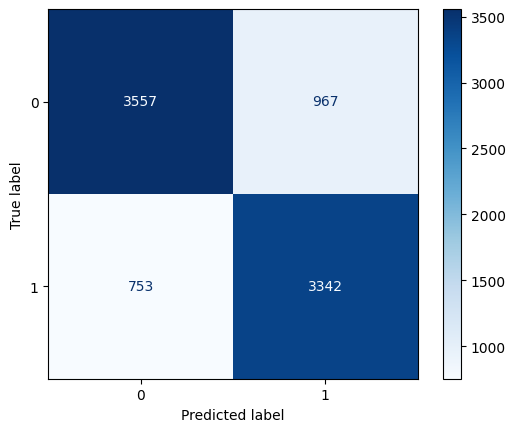

In [69]:
predictions = model.predict(testing_padded)
binary_predictions = [1 if x > 0.5 else 0 for x in predictions]
cm = confusion_matrix(testing_labels, binary_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

num_iter = 1 
f_name = f'file_{num_iter}.png'
if os.path.exists(f_name):
    num_iter += 1
    f_name = f'file_{num_iter}.png'
    
plt.savefig(f_name)
plt.show()